You should implement five learning algorithms. They are:

Decision trees with some form of pruning
Neural networks
Boosting
Support Vector Machines
k-nearest neighbors

In [27]:
import pandas as pd
import numpy as np
import gc
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import yellowbrick
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics #Import scikit-learn metrics module for ac
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer


from geopy.distance import geodesic # formerly vincenty
import imblearn
from imblearn.over_sampling import SMOTE

from yellowbrick.target import ClassBalance
from yellowbrick.model_selection import LearningCurve
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.target import class_balance
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport


np.random.seed(42)

https://www.kaggle.com/datasets/camnugent/california-housing-prices?datasetId=5227&sortBy=voteCount

# Geospatial Feature Engineering


https://www.kaggle.com/code/camnugent/geospatial-feature-engineering-and-visualization

In [22]:
url = 'https://raw.githubusercontent.com/AaronScherf/ML_As1_SL/main/housing.csv'
housing = pd.read_csv(url)

url = 'https://raw.githubusercontent.com/AaronScherf/ML_As1_SL/main/cal_cities_lat_long.csv'
city_lat_long = pd.read_csv(url)

url = 'https://raw.githubusercontent.com/AaronScherf/ML_As1_SL/main/cal_populations_city.csv'
city_pop_data = pd.read_csv(url)

url = 'https://raw.githubusercontent.com/AaronScherf/ML_As1_SL/main/cal_populations_county.csv'
county_pop_data = pd.read_csv(url)


In [23]:
#########
# Engineer more features here prior to
# passing data in for imputation and one hot encoding
#########

city_coords = {}

for dat in city_lat_long.iterrows():
    row = dat[1]
    if row['Name'] not in city_pop_data['City'].values:
        continue
    else:
        city_coords[row['Name']] = (float(row['Latitude']), float(row['Longitude']))


In [24]:
def closest_point(location, location_dict):
    """ take a tuple of latitude and longitude and
        compare to a dictonary of locations where
        key = location name and value = (lat, long)
        returns tuple of (closest_location , distance) """
    closest_location = None
    for city in location_dict.keys():
        distance = geodesic(location, location_dict[city]).kilometers
        if closest_location is None:
            closest_location = (city, distance)
        elif distance < closest_location[1]:
            closest_location = (city, distance)
    return closest_location

In [25]:
city_pop_dict = {}
for dat in city_pop_data.iterrows():
    row = dat[1]
    city_pop_dict[row['City']] =  row['pop_april_1990']

big_cities = {}

for key, value in city_coords.items():
    if city_pop_dict[key] > 500000:
        big_cities[key] = value

In [ ]:
#######
# adding closest city data to dataframes
#######

housing['close_city'] = housing.apply(lambda x:
							closest_point((x['latitude'],x['longitude']),city_coords), axis = 1)
housing['close_city_name'] = [x[0] for x in housing['close_city'].values]
housing['close_city_dist'] = [x[1] for x in housing['close_city'].values]
housing['close_city_pop'] = [city_pop_dict[x] for x in housing['close_city_name'].values]

housing = housing.drop('close_city', axis=1)
housing.head()

#add the data relating to the points to the closest big city
housing['big_city'] = housing.apply(lambda x:
							closest_point((x['latitude'],x['longitude']),big_cities), axis = 1)
housing['big_city_name'] = [x[0] for x in housing['big_city'].values]
housing['big_city_dist'] = [x[1] for x in housing['big_city'].values]

housing = housing.drop('big_city', axis=1)

In [ ]:
#####
# Alter existing features
#####

# Divide by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Label those above 5 as 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
#this change below is because column names can't be passed to xgboost with a < symbol
housing['ocean_proximity'][housing['ocean_proximity'] == '<1H OCEAN'] = 'LessThan1h'

housing.drop("income_cat",axis=1,inplace=True)

gc.collect()

def housing_data_clean(input_df):
	input_df['rooms_per_household'] = input_df['total_rooms']/input_df['households']
	input_df['bedrooms_per_household'] = input_df['total_bedrooms']/input_df['households']
	input_df['bedrooms_per_room'] = input_df['total_bedrooms']/input_df['total_rooms']
	input_df['population_per_household'] = input_df['population']/input_df['households']
	input_df = input_df.drop(['total_bedrooms','total_rooms'], axis=1)
	return input_df

clean_house = housing_data_clean(housing)


In [ ]:

#####
# fill numerical values
#####

def fill_median(dataframe, cols):
	"""impute the mean for a list of columns in the dataframe"""
	for i in cols:
		dataframe[i].fillna(dataframe[i].median(skipna=True), inplace = True)
	return dataframe

def cols_with_missing_values(dataframe):
	""" query a dataframe and find the columns that have missing values"""
	return list(dataframe.columns[dataframe.isnull().any()])

def fill_value(dataframe, col, val):
	"""impute the value for a list column in the dataframe"""
	""" use this to impute the median of the train into the test"""
	dataframe[i].fillna(val, inplace = True)
	return dataframe

missing_vals = cols_with_missing_values(clean_house)
clean_house = fill_median(clean_house, missing_vals)


In [ ]:
#####
# One hot encode the categoricals
#####

encoder1 = LabelBinarizer()
encoded_ocean_train_1hot = encoder1.fit_transform(clean_house['ocean_proximity'])

encoder2 = LabelBinarizer()
encoded_train_close_city = encoder2.fit_transform(clean_house['close_city_name'])

encoder3 = LabelBinarizer()
encoded_train_big_city = encoder3.fit_transform(clean_house['big_city_name'])

all_classes = list(encoder1.classes_) + [x + '_city' for x in encoder2.classes_ ]  + [x + '_Bigcity' for x in encoder3.classes_]

train_bool_data = np.concatenate((encoded_ocean_train_1hot, encoded_train_close_city, encoded_train_big_city), axis=1)

train_cat_df = pd.DataFrame(train_bool_data,
	index = clean_house.index, columns = all_classes )


In [ ]:
###
# Combine and scale the dfs
###

clean_house.drop(['ocean_proximity','close_city_name','big_city_name'], axis=1, inplace=True)

num_cols = clean_house.columns
num_train_index = clean_house.index

X_temp = pd.DataFrame(clean_house,index = num_train_index, columns = num_cols)

X = pd.concat([X_temp, train_cat_df], axis=1)

y = X['median_house_value'].values.astype(float)
X = X.drop('median_house_value', axis=1)

gc.collect()

In [ ]:
X.to_csv('/content/gdrive/My Drive/OMSCS/Machine Learning/As1 SL/X_housing.csv', index=False)
#X_test.to_csv('/content/gdrive/My Drive/OMSCS/Machine Learning/As1 SL/X_test.csv', index=False)
pd.DataFrame(y).to_csv('/content/gdrive/My Drive/OMSCS/Machine Learning/As1 SL/y_housing.csv', index=False)
#pd.DataFrame(y_test).to_csv('/content/gdrive/My Drive/OMSCS/Machine Learning/As1 SL/y_test.csv', index=False)


# Importing Clean Data

In [52]:
url = 'https://raw.githubusercontent.com/AaronScherf/ML_As1_SL/main/X_housing.csv'
X_housing = pd.read_csv(url)

url = 'https://raw.githubusercontent.com/AaronScherf/ML_As1_SL/main/y_housing.csv'
y_housing = pd.read_csv(url)


In [53]:
to_drop = X_housing.sample(frac = 0.5)

X_housing = X_housing.drop(to_drop.index)
y_housing = y_housing.drop(to_drop.index)

In [54]:
X_housing.shape

(10320, 453)

In [55]:
y_housing.shape

(10320, 1)

In [56]:
X_housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'population',
       'households', 'median_income', 'close_city_dist', 'close_city_pop',
       'big_city_dist', 'rooms_per_household',
       ...
       'Woodlake_city', 'Woodland_city', 'Yorba Linda_city', 'Yreka_city',
       'Yuba City_city', 'Yucaipa_city', 'Los Angeles_Bigcity',
       'San Diego_Bigcity', 'San Francisco_Bigcity', 'San Jose_Bigcity'],
      dtype='object', length=453)

https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction

In [57]:
url = 'https://raw.githubusercontent.com/AaronScherf/ML_As1_SL/main/data.csv'
bankrupt = pd.read_csv(url)
y_bankrupt = pd.DataFrame(bankrupt['Bankrupt?'].values.astype(int))
X_bankrupt = bankrupt.drop('Bankrupt?', axis=1)
X_bankrupt.drop(' Liability-Assets Flag',axis=1, inplace=True)

# Explore Data

In [37]:
# importing custom matplotlib parameters for vizualizations
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['figure.frameon'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams["font.family"] = "monospace";

# Color Palettes
colors = ["#bfd3e6", "#9b5b4f", "#4e4151", "#dbba78", "#bb9c55", "#909195","#dc1e1e","#a02933","#716807","#717cb4"]


<ipython-input-38-c34c5c17f928>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_housing['0'],color=colors[7])


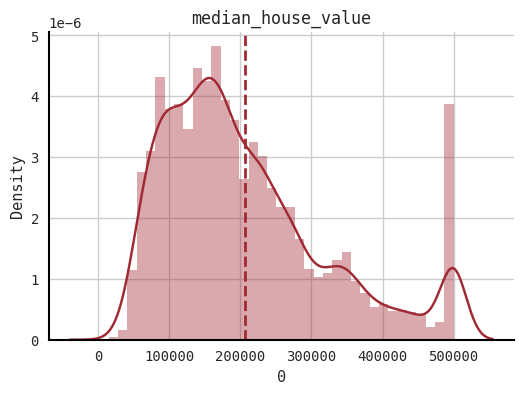

In [38]:
#checking the target variables for distribution
sns.distplot(y_housing['0'],color=colors[7])
plt.axvline(x=y_housing['0'].mean(), color=colors[7], linestyle='--', linewidth=2)
plt.title('median_house_value');

In [39]:
y_housing.describe()

,0
count,10320.000000
mean,206547.633721
std,115660.784595
min,14999.000000
25%,119300.000000
50%,178900.000000
75%,263600.000000
max,500001.000000


In [58]:
# categorize housing data
y_housing = y_housing < y_housing.median()
y_housing = y_housing.astype(int)
y_housing

,0
0,0
2,0
3,0
8,0
10,0
...,...
20631,1
20633,1
20635,1
20638,1


In [42]:
y_housing.describe()

,0
count,10320.000000
mean,0.499903
std,0.500024
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


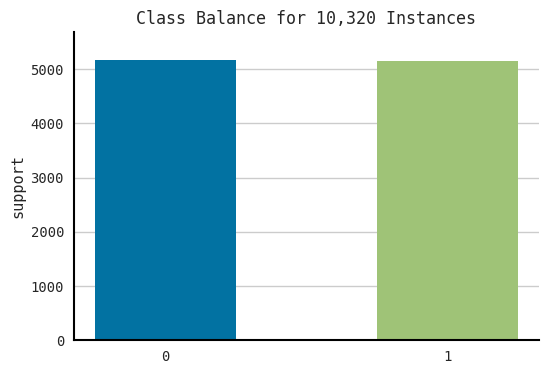

<Axes: title={'center': 'Class Balance for 10,320 Instances'}, ylabel='support'>

In [59]:

# Instantiate the visualizer
visualizer = ClassBalance(labels=["0", "1"])

visualizer.fit(y_housing['0'])        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [60]:
X_bankrupt.shape

(6819, 94)

In [45]:
X_bankrupt.describe()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,0.012679,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,0.781567,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,0.781635,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,0.781735,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


In [15]:
y_bankrupt.describe()

,0
count,6819.000000
mean,0.032263
std,0.176710
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


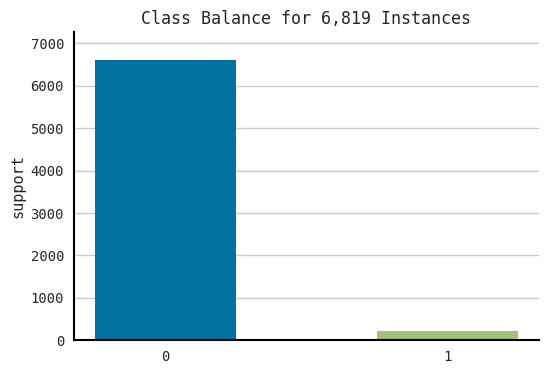

<Axes: title={'center': 'Class Balance for 6,819 Instances'}, ylabel='support'>

In [61]:

# Class balance for bankruptcy data
visualizer = ClassBalance(labels=["0", "1"])

visualizer.fit(y_bankrupt[0])        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [62]:
# oversample bankrupt cases with SMOTE to provide more examples for classification
oversample = SMOTE(sampling_strategy=0.2,random_state=42)
X_bankrupt, y_bankrupt = oversample.fit_resample(X_bankrupt, y_bankrupt)

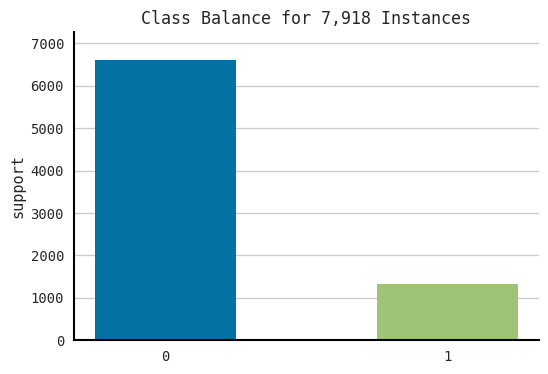

<Axes: title={'center': 'Class Balance for 7,918 Instances'}, ylabel='support'>

In [63]:

# Class balance for bankruptcy data
visualizer = ClassBalance(labels=["0", "1"])

visualizer.fit(y_bankrupt[0])        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [64]:
y_bankrupt.describe()

,0
count,7918.000000
mean,0.166582
std,0.372626
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


# Model Training and Visualization

In [65]:
# https://stackoverflow.com/questions/46912557/is-it-possible-to-get-test-scores-for-each-iteration-of-mlpclassifier

def MLP_eval(estimator,X_train,y_train,X_test,y_test,epochs):
    N_TRAIN_SAMPLES = X_train.shape[0]
    N_EPOCHS = epochs
    N_CLASSES = np.unique(y_train)

    scores_train = []
    scores_test = []

    # EPOCH
    epoch = 0
    while epoch < N_EPOCHS:
        estimator.fit(X_train,y_train)

        # SCORE TRAIN
        y_preds_train = estimator.predict(X_train)
        scores_train.append(f1_score(y_train, y_preds_train))

        # SCORE TEST
        y_preds_test = estimator.predict(X_test)
        scores_test.append(f1_score(y_test, y_preds_test))

        epoch += 1

    """ Plot """
    plt.plot(scores_train, color='green', alpha=0.8, label='Train')
    plt.plot(scores_test, color='magenta', alpha=0.8, label='Test')
    plt.title("f1 over epochs", fontsize=14)
    plt.xlabel('Epochs')
    plt.legend(loc='upper left')
    plt.show()


In [66]:
# cobbled together this evaluation function wrapper from yellowbrick documentation

def eval_model(estimator, X, y, param_1_name,param_1_range,param_2_name,param_2_range, n_splits,labels,test_size):
    model_name = estimator.__class__.__name__

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
    y_train = y_train[y_train.columns[0]]
    y_test = y_test[y_test.columns[0]]

    if len(X)==20640: # housing data
        numeric_columns=list(X_housing.iloc[:,:13].columns)
        ct = ColumnTransformer([('num',StandardScaler(),numeric_columns)],remainder='passthrough')

        X_train = pd.DataFrame(ct.fit_transform(X_train))
        X_test = pd.DataFrame(ct.transform(X_test))
    else: # bankruptcy data
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)

    # Class Balance visualization
    visualizer = ClassBalance(labels=labels)

    visualizer.fit(y_train, y_test)
    visualizer.show()                      # Finalize and render the figure

    cv = KFold(n_splits=n_splits)
    gs = GridSearchCV(estimator=estimator, param_grid={param_1_name:param_1_range,param_2_name:param_2_range},cv=cv,scoring='f1_weighted')
    gs.fit(X_train, y_train)
    print("Grid Search best params: ", gs.best_params_)

    mean_fit_time= gs.cv_results_['mean_fit_time']
    mean_score_time= gs.cv_results_['mean_score_time']
    print("mean_fit_score_time by paramm: ", pd.DataFrame(mean_fit_time+mean_score_time,index=gs.cv_results_['params']))
    n_iter = pd.DataFrame(gs.cv_results_).shape[0]
    print("Grid search time: ", np.mean(mean_fit_time + mean_score_time) * gs.n_splits_ * n_iter)

    best_est_train = gs.best_estimator_
    best_est_train.fit(X_train,y_train)

    if model_name == 'MLPClassifier':
        # search across a hyperparameter to tune across CV
        viz = ValidationCurve(
        best_est_train, param_name=param_1_name,
        param_range=[x[0] for x in param_1_range], cv=cv, scoring="f1_weighted"
        )

        # Fit and show the visualizer; store as an image
        viz.fit(X_train, y_train)
                    # export the validation curve image
        viz.show()

    else:
            # search across a hyperparameter to tune across CV
        viz = ValidationCurve(
        best_est_train, param_name=param_1_name,
        param_range=param_1_range, cv=cv, scoring="f1_weighted"
        )

        # Fit and show the visualizer
        viz.fit(X_train, y_train)
        viz.show()

    # search across a hyperparameter to tune across CV
    viz = ValidationCurve(
    best_est_train, param_name=param_2_name,
    param_range=param_2_range, cv=cv, scoring="f1_weighted"
    )

    # Fit and show the visualizer
    viz.fit(X_train, y_train)
    viz.show()

    if model_name == 'MLPClassifier':
        MLP_eval(estimator=best_est_train,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test,epochs=50)

    else:
        visualizer = LearningCurve(
            best_est_train, cv=cv, scoring='f1_weighted', train_sizes=np.linspace(0.1,1.0,5), n_jobs=4
        )

        visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
        visualizer.show()           # Finalize and render the figure

    # Classification report and confusion matrix
    visualizer = ClassificationReport(best_est_train, classes=labels, support=True)

    visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
    visualizer.score(X_test, y_test)        # Evaluate the model on the test data
    visualizer.show()                       # Finalize and show the figure

    # The ConfusionMatrix visualizer taxes a model
    cm = ConfusionMatrix(best_est_train, classes=labels)
    cm.fit(X_train, y_train)
    cm.score(X_test, y_test)
    cm.show()


Decision Trees. For the decision tree, you should implement or steal a decision tree algorithm (and by "implement or steal" I mean "steal"). Be sure to use some form of pruning. You are not required to use information gain (for example, there is something called the GINI index that is sometimes used) to split attributes, but you should describe whatever it is that you do use.

https://www.datacamp.com/tutorial/decision-tree-classification-python


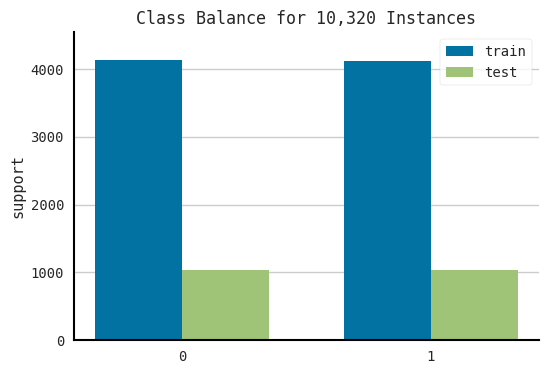

Grid Search best params:  {'criterion': 'gini', 'max_depth': 9}
mean_fit_score_time by paramm:                                                     0
{'criterion': 'gini', 'max_depth': 1}       0.079991
{'criterion': 'gini', 'max_depth': 5}       0.205225
{'criterion': 'gini', 'max_depth': 9}       0.362160
{'criterion': 'gini', 'max_depth': 13}      0.313434
{'criterion': 'gini', 'max_depth': 17}      0.347743
{'criterion': 'entropy', 'max_depth': 1}    0.080451
{'criterion': 'entropy', 'max_depth': 5}    0.219937
{'criterion': 'entropy', 'max_depth': 9}    0.352701
{'criterion': 'entropy', 'max_depth': 13}   0.294695
{'criterion': 'entropy', 'max_depth': 17}   0.299518
{'criterion': 'log_loss', 'max_depth': 1}   0.080965
{'criterion': 'log_loss', 'max_depth': 5}   0.212778
{'criterion': 'log_loss', 'max_depth': 9}   0.358126
{'criterion': 'log_loss', 'max_depth': 13}  0.302953
{'criterion': 'log_loss', 'max_depth': 17}  0.298997
Grid search time:  38.096755027770996


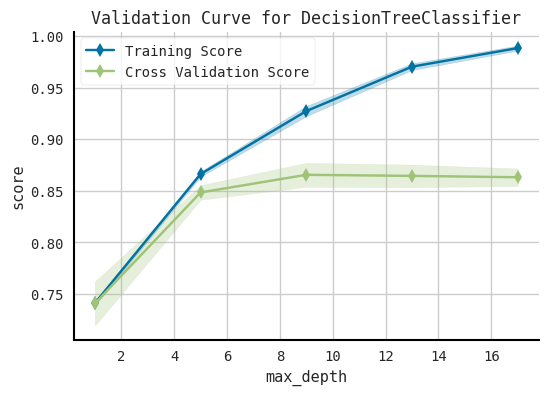

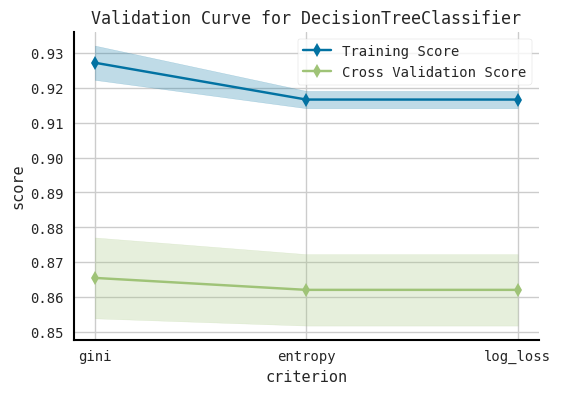

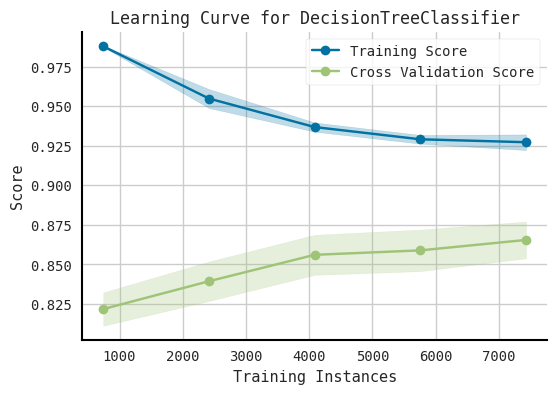

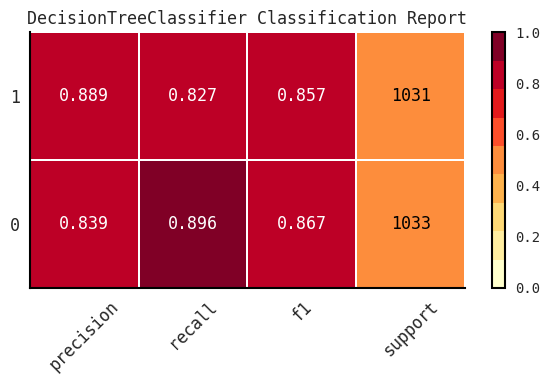

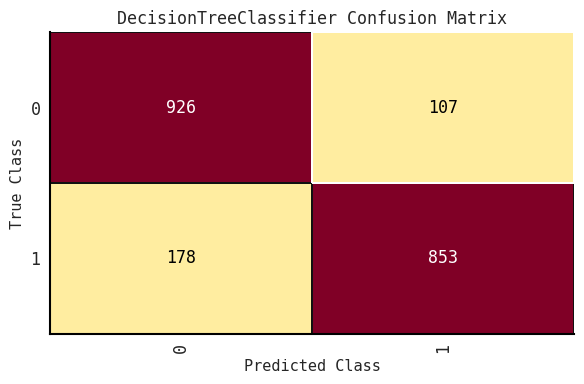

In [67]:
eval_model(estimator=DecisionTreeClassifier(random_state=42), X=X_housing, y=y_housing,
                       param_1_name='max_depth',param_1_range = [1,5,9,13,17],
                       param_2_name='criterion',param_2_range = ['gini','entropy','log_loss'],
                       n_splits=10,labels=['0','1'],test_size=0.2)

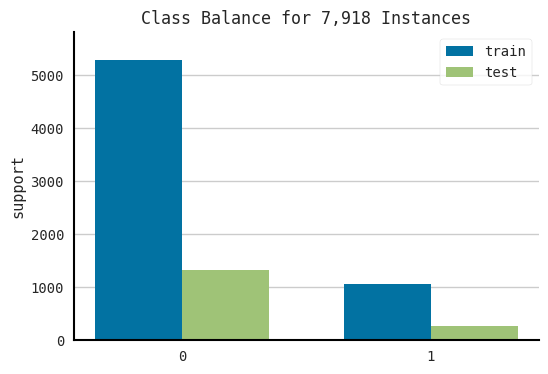

Grid Search best params:  {'criterion': 'entropy', 'max_depth': 13}
mean_fit_score_time by paramm:                                                     0
{'criterion': 'gini', 'max_depth': 1}       0.062987
{'criterion': 'gini', 'max_depth': 5}       0.269934
{'criterion': 'gini', 'max_depth': 9}       0.520296
{'criterion': 'gini', 'max_depth': 13}      0.603256
{'criterion': 'gini', 'max_depth': 17}      0.657213
{'criterion': 'entropy', 'max_depth': 1}    0.115086
{'criterion': 'entropy', 'max_depth': 5}    0.325037
{'criterion': 'entropy', 'max_depth': 9}    0.380501
{'criterion': 'entropy', 'max_depth': 13}   0.419297
{'criterion': 'entropy', 'max_depth': 17}   0.472173
{'criterion': 'log_loss', 'max_depth': 1}   0.076831
{'criterion': 'log_loss', 'max_depth': 5}   0.308473
{'criterion': 'log_loss', 'max_depth': 9}   0.381574
{'criterion': 'log_loss', 'max_depth': 13}  0.499067
{'criterion': 'log_loss', 'max_depth': 17}  0.390948
Grid search time:  54.826737403869636


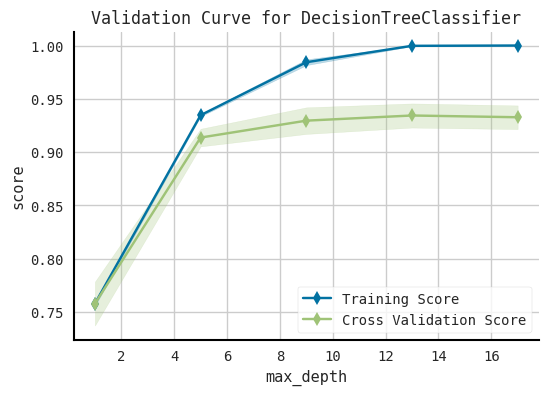

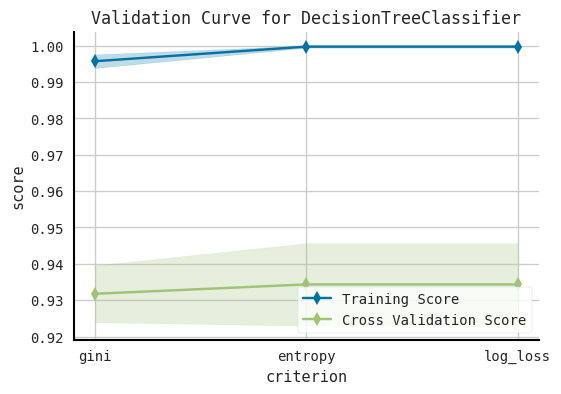

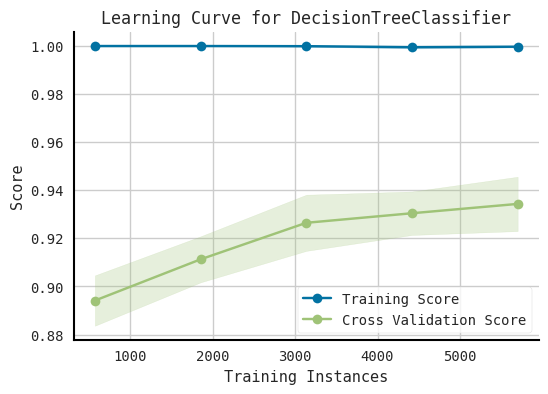

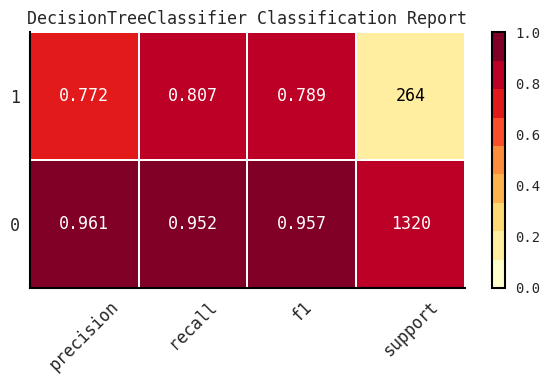

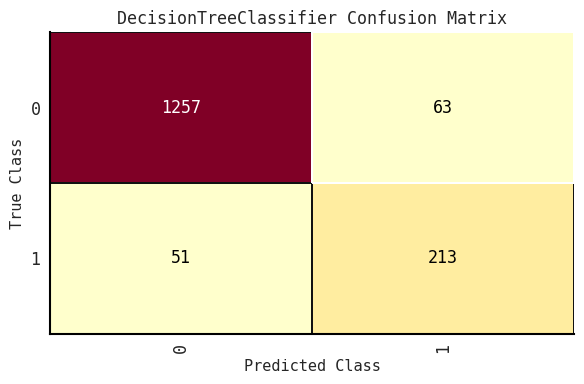

In [68]:
eval_model(estimator=DecisionTreeClassifier(random_state=42), X=X_bankrupt, y=y_bankrupt,
                       param_1_name='max_depth',param_1_range = [1,5,9,13,17],
                       param_2_name='criterion',param_2_range = ['gini','entropy','log_loss'],
                       n_splits=10,labels=['0','1'],test_size=0.2)

Neural Networks. For the neural network you should implement or steal your favorite kind of network and training algorithm. You may use networks of nodes with as many layers as you like and any activation function you see fit.

https://www.pluralsight.com/guides/machine-learning-neural-networks-scikit-learn

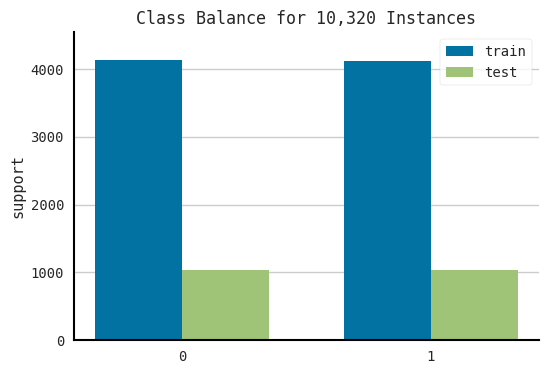

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Grid Search best params:  {'alpha': 0.0003, 'hidden_layer_sizes': (10,)}
mean_fit_score_time by paramm:                                                          0
{'alpha': 0.0001, 'hidden_layer_sizes': (5,)}   11.102771
{'alpha': 0.0001, 'hidden_layer_sizes': (10,)}  10.615269
{'alpha': 0.0001, 'hidden_layer_sizes': (20,)}  12.214729
{'alpha': 0.0002, 'hidden_layer_sizes': (5,)}    9.949924
{'alpha': 0.0002, 'hidden_layer_sizes': (10,)}  10.725803
{'alpha': 0.0002, 'hidden_layer_sizes': (20,)}  12.195395
{'alpha': 0.0003, 'hidden_layer_sizes': (5,)}   10.108484
{'alpha': 0.0003, 'hidden_layer_sizes': (10,)}  10.644122
{'alpha': 0.0003, 'hidden_layer_sizes': (20,)}  12.632555
Grid search time:  1001.8905053138732


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

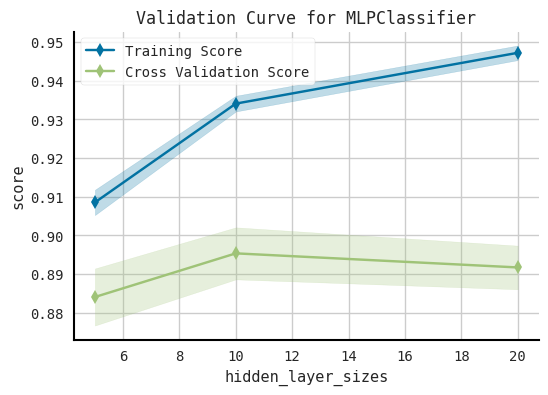

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

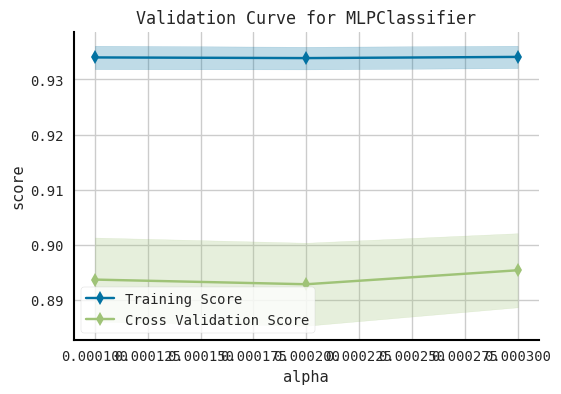

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

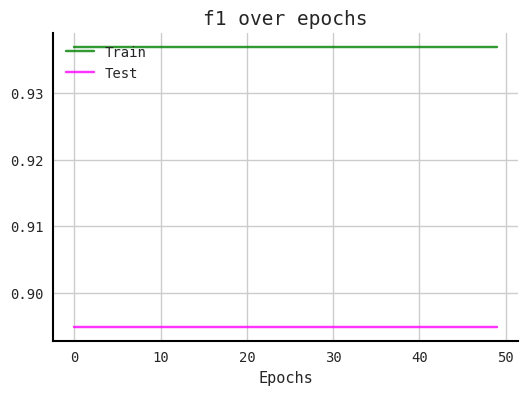

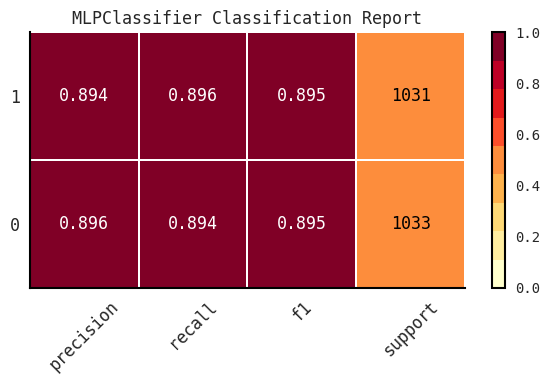

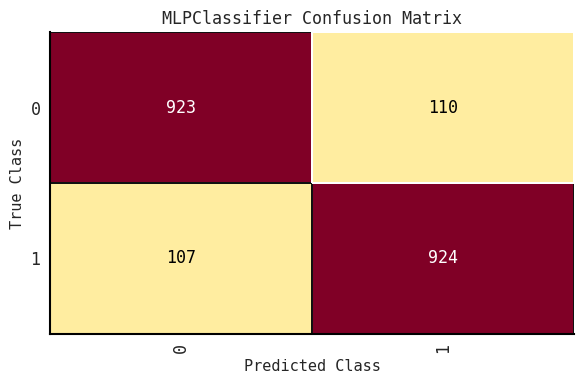

In [80]:
from sklearn.neural_network import MLPClassifier
eval_model(estimator=MLPClassifier(random_state=42), X=X_housing, y=y_housing,
                       param_1_name='hidden_layer_sizes',param_1_range = [(5,),(10,),(20,)],
                       param_2_name='alpha',param_2_range = [0.0001,0.0002,0.0003],
                       n_splits=10,labels=['0','1'],test_size=0.2)

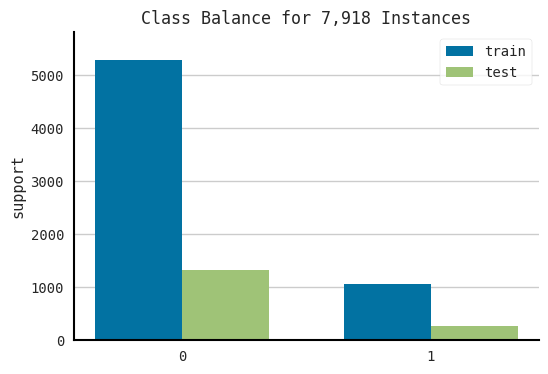

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Grid Search best params:  {'alpha': 0.0002, 'hidden_layer_sizes': (20,)}
mean_fit_score_time by paramm:                                                         0
{'alpha': 0.0001, 'hidden_layer_sizes': (5,)}   2.611265
{'alpha': 0.0001, 'hidden_layer_sizes': (10,)}  2.842007
{'alpha': 0.0001, 'hidden_layer_sizes': (20,)}  5.225043
{'alpha': 0.0002, 'hidden_layer_sizes': (5,)}   2.630235
{'alpha': 0.0002, 'hidden_layer_sizes': (10,)}  2.842921
{'alpha': 0.0002, 'hidden_layer_sizes': (20,)}  5.178712
{'alpha': 0.0003, 'hidden_layer_sizes': (5,)}   2.635332
{'alpha': 0.0003, 'hidden_layer_sizes': (10,)}  2.877785
{'alpha': 0.0003, 'hidden_layer_sizes': (20,)}  5.161844
Grid search time:  320.05142974853516


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

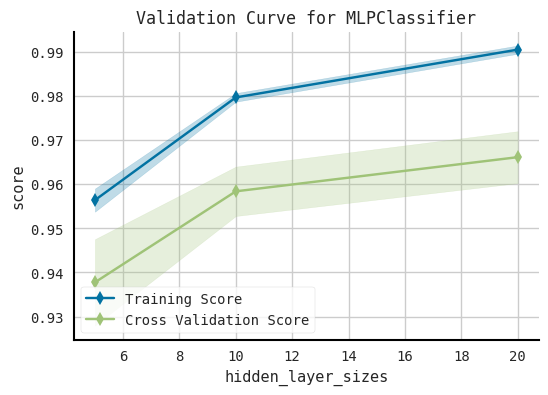

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

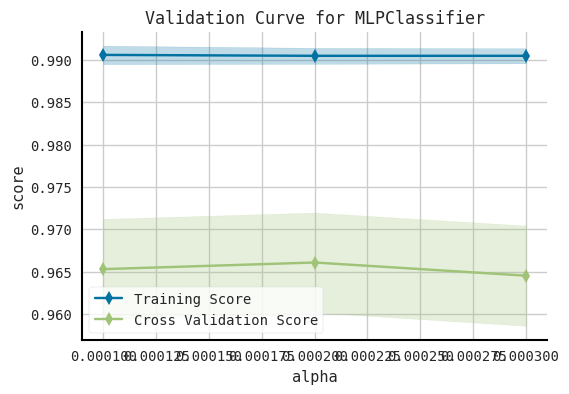

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

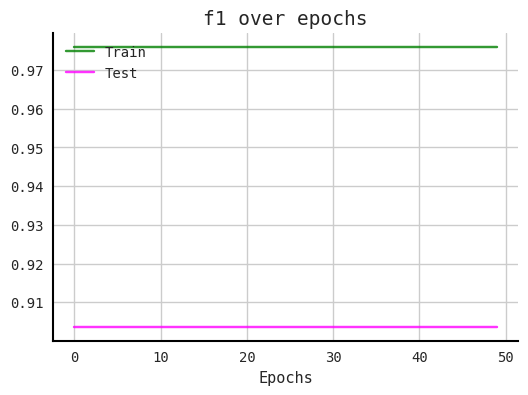

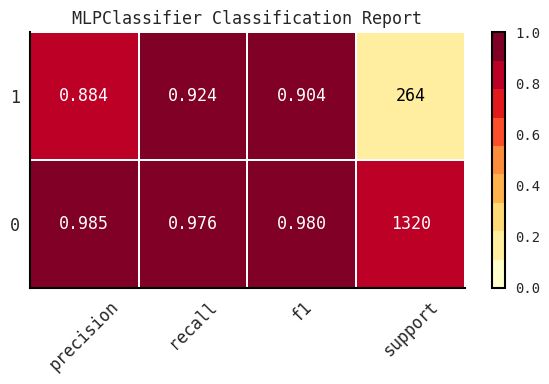

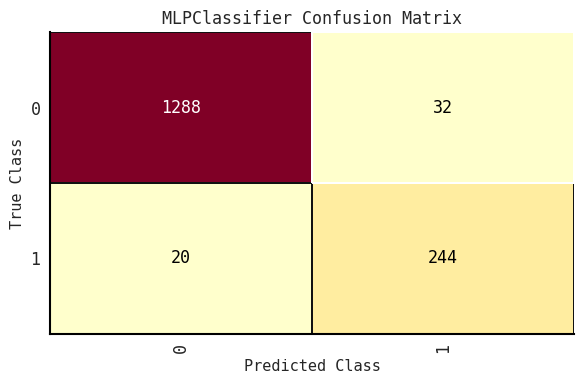

In [81]:
from sklearn.neural_network import MLPClassifier
eval_model(estimator=MLPClassifier(random_state=42), X=X_bankrupt, y=y_bankrupt,
                       param_1_name='hidden_layer_sizes',param_1_range = [(5,),(10,),(20,)],
                       param_2_name='alpha',param_2_range = [0.0001,0.0002,0.0003],
                       n_splits=10,labels=['0','1'],test_size=0.2)

Boosting. Implement or steal a boosted version of your decision trees. As before, you will want to use some form of pruning, but presumably because you're using boosting you can afford to be much more aggressive about your pruning.


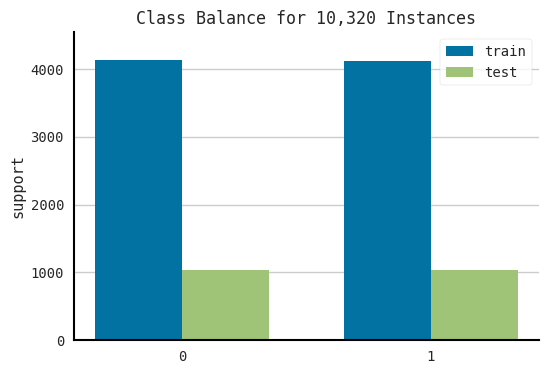

Grid Search best params:  {'learning_rate': 0.5, 'n_estimators': 200}
mean_fit_score_time by paramm:                                                       0
{'learning_rate': 0.1, 'n_estimators': 50}    3.139398
{'learning_rate': 0.1, 'n_estimators': 100}   4.597683
{'learning_rate': 0.1, 'n_estimators': 200}   9.375966
{'learning_rate': 0.3, 'n_estimators': 50}    2.413128
{'learning_rate': 0.3, 'n_estimators': 100}   4.521223
{'learning_rate': 0.3, 'n_estimators': 200}   9.596770
{'learning_rate': 0.5, 'n_estimators': 50}    2.303369
{'learning_rate': 0.5, 'n_estimators': 100}   4.728901
{'learning_rate': 0.5, 'n_estimators': 200}  11.183817
Grid search time:  518.6025502681732


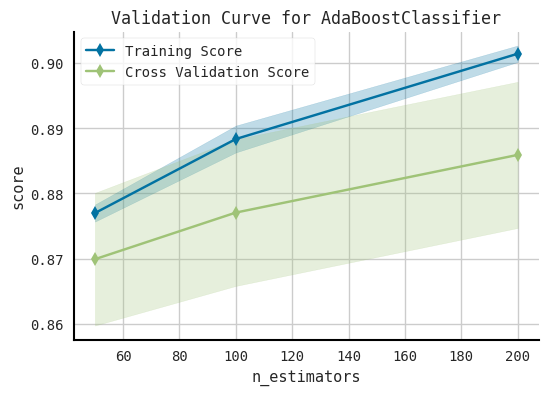

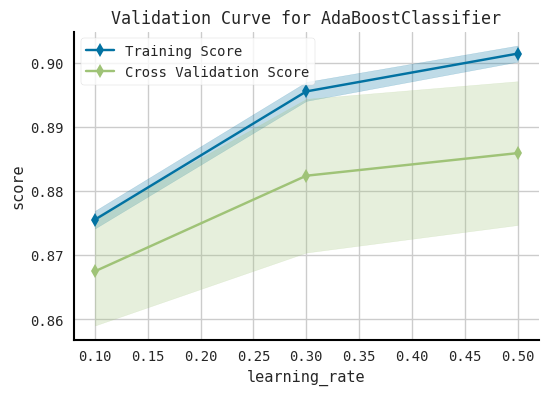

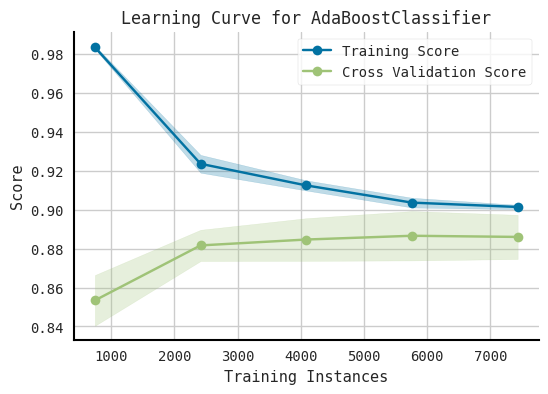

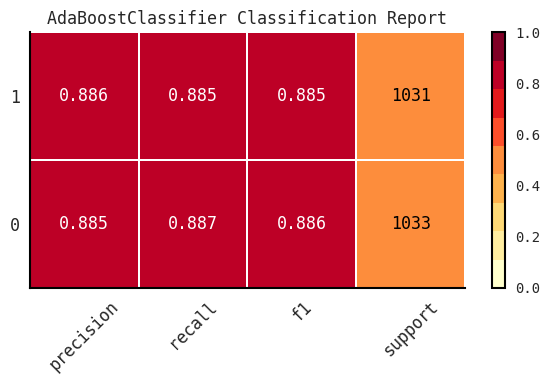

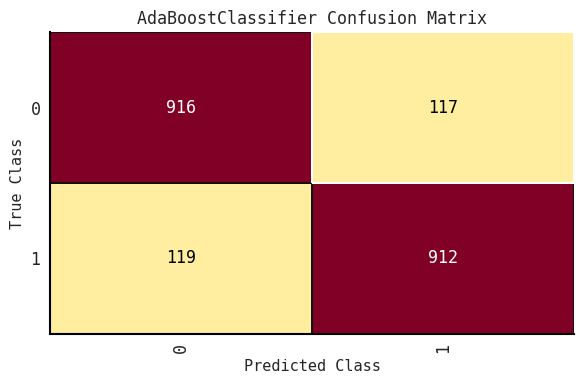

In [70]:
from sklearn.ensemble import AdaBoostClassifier

eval_model(estimator=AdaBoostClassifier(random_state=42), X=X_housing, y=y_housing,
                       param_1_name='n_estimators',param_1_range = [50,100,200],
                       param_2_name='learning_rate',param_2_range = [0.1,0.3,0.5],
                       n_splits=10,labels=['0','1'],test_size=0.2)

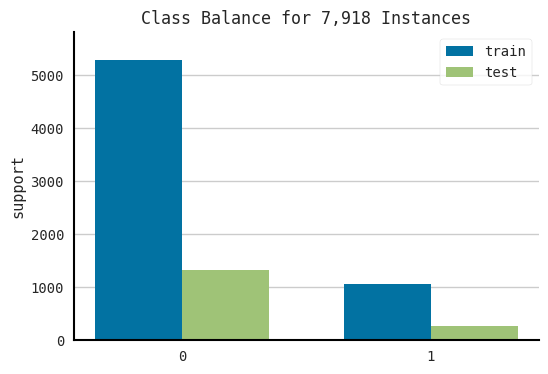

Grid Search best params:  {'learning_rate': 0.5, 'n_estimators': 200}
mean_fit_score_time by paramm:                                                       0
{'learning_rate': 0.1, 'n_estimators': 50}    3.412135
{'learning_rate': 0.1, 'n_estimators': 100}   6.733157
{'learning_rate': 0.1, 'n_estimators': 200}  13.418283
{'learning_rate': 0.3, 'n_estimators': 50}    3.319985
{'learning_rate': 0.3, 'n_estimators': 100}   6.792240
{'learning_rate': 0.3, 'n_estimators': 200}  13.427960
{'learning_rate': 0.5, 'n_estimators': 50}    3.343608
{'learning_rate': 0.5, 'n_estimators': 100}   6.730764
{'learning_rate': 0.5, 'n_estimators': 200}  13.390982
Grid search time:  705.6911528110504


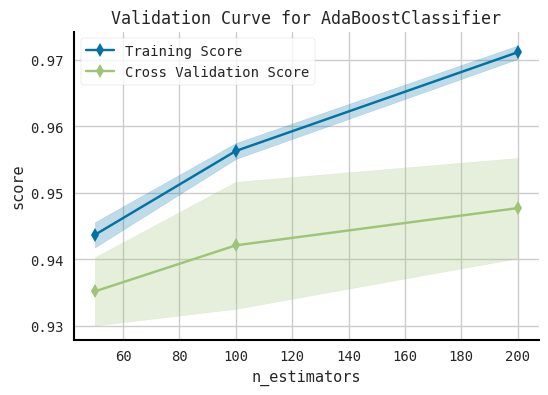

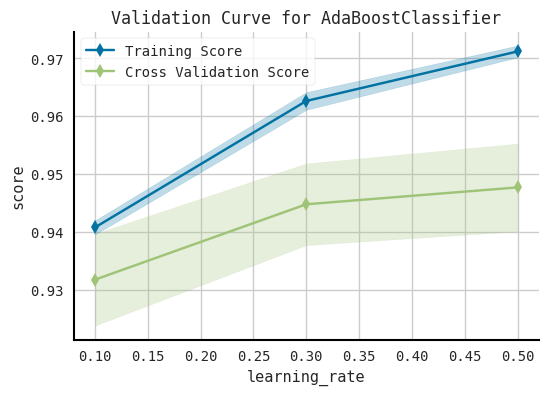

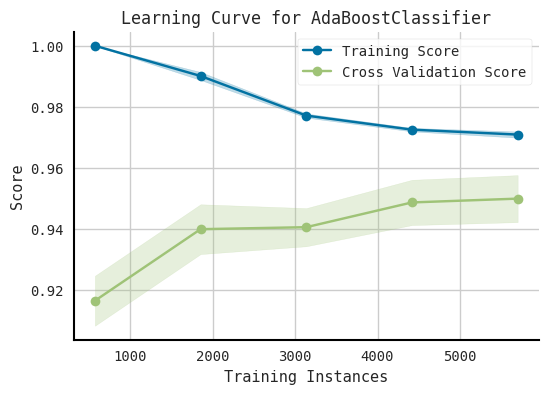

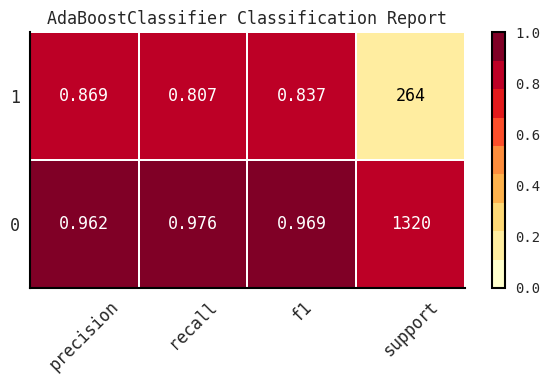

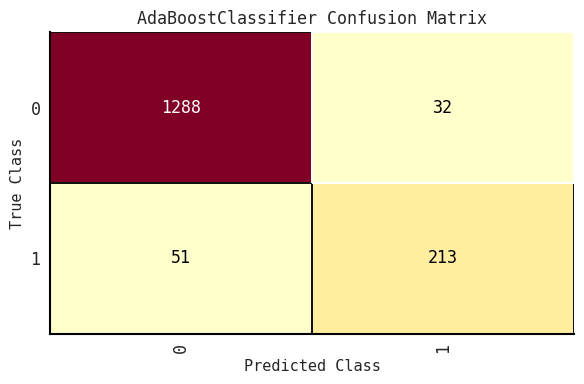

In [71]:
from sklearn.ensemble import AdaBoostClassifier

eval_model(estimator=AdaBoostClassifier(random_state=42), X=X_bankrupt, y=y_bankrupt,
                       param_1_name='n_estimators',param_1_range = [50,100,200],
                       param_2_name='learning_rate',param_2_range = [0.1,0.3,0.5],
                       n_splits=10,labels=['0','1'],test_size=0.2)

Support Vector Machines. You should implement (for sufficiently loose definitions of implement including "download") SVMs. This should be done in such a way that you can swap out kernel functions. I'd like to see at least two.


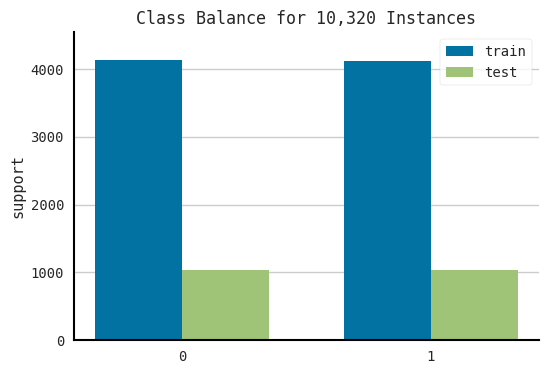

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-

Grid Search best params:  {'kernel': 'sigmoid', 'max_iter': 700}
mean_fit_score_time by paramm:                                                 0
{'kernel': 'sigmoid', 'max_iter': 100}  0.549073
{'kernel': 'sigmoid', 'max_iter': 300}  1.488691
{'kernel': 'sigmoid', 'max_iter': 500}  2.452523
{'kernel': 'sigmoid', 'max_iter': 700}  3.429887
{'kernel': 'poly', 'max_iter': 100}     0.456483
{'kernel': 'poly', 'max_iter': 300}     1.326002
{'kernel': 'poly', 'max_iter': 500}     2.156775
{'kernel': 'poly', 'max_iter': 700}     3.189447
{'kernel': 'rbf', 'max_iter': 100}      0.552225
{'kernel': 'rbf', 'max_iter': 300}      1.564330
{'kernel': 'rbf', 'max_iter': 500}      2.548529
{'kernel': 'rbf', 'max_iter': 700}      3.550076
Grid search time:  232.64040088653562


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=700).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=700).  Consider pre-

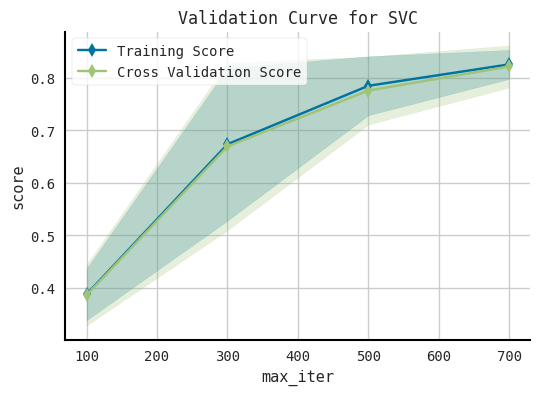

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=700).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=700).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=700).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=700).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=700).  Consider pre-

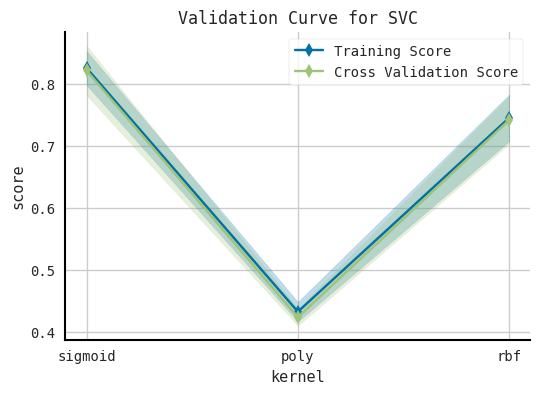

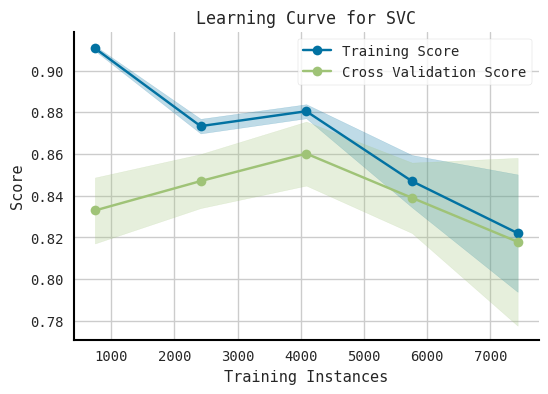

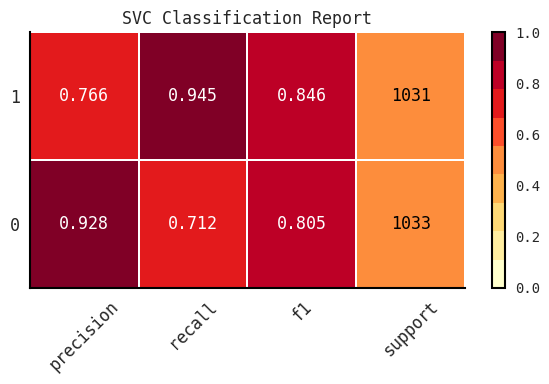

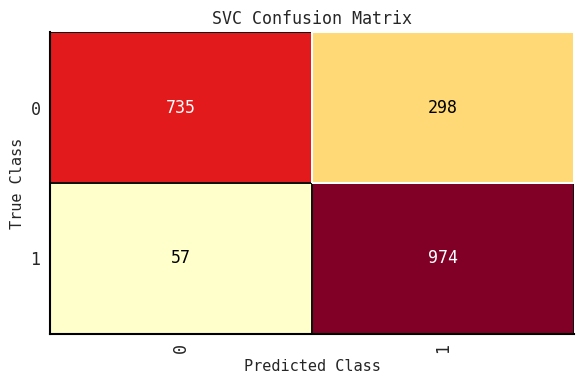

In [76]:
# https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python

#Import svm model
from sklearn.svm import SVC

eval_model(estimator=SVC(random_state=42), X=X_housing, y=y_housing,
                       param_1_name='max_iter',param_1_range = [100,300,500,700],
                       param_2_name='kernel',param_2_range = ['sigmoid','poly','rbf'],
                       n_splits=10,labels=['0','1'],test_size=0.2)

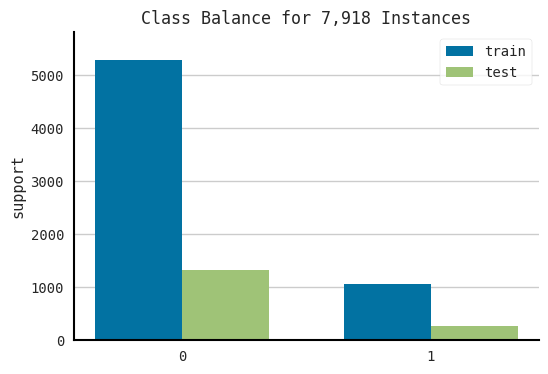

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-

Grid Search best params:  {'kernel': 'rbf', 'max_iter': 700}
mean_fit_score_time by paramm:                                                 0
{'kernel': 'sigmoid', 'max_iter': 100}  0.141665
{'kernel': 'sigmoid', 'max_iter': 300}  0.444679
{'kernel': 'sigmoid', 'max_iter': 500}  0.619256
{'kernel': 'sigmoid', 'max_iter': 700}  0.829926
{'kernel': 'poly', 'max_iter': 100}     0.060443
{'kernel': 'poly', 'max_iter': 300}     0.179643
{'kernel': 'poly', 'max_iter': 500}     0.329673
{'kernel': 'poly', 'max_iter': 700}     0.498835
{'kernel': 'rbf', 'max_iter': 100}      0.170329
{'kernel': 'rbf', 'max_iter': 300}      0.393033
{'kernel': 'rbf', 'max_iter': 500}      0.529162
{'kernel': 'rbf', 'max_iter': 700}      0.845921
Grid search time:  50.42564868927002


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=700).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=700).  Consider pre-

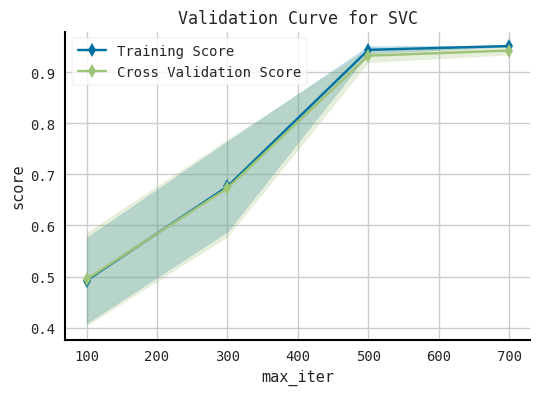

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=700).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=700).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=700).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=700).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=700).  Consider pre-

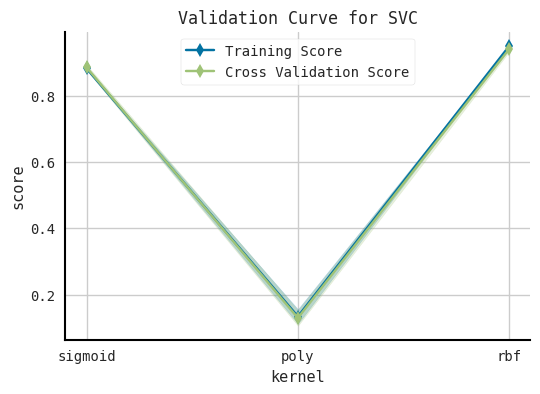

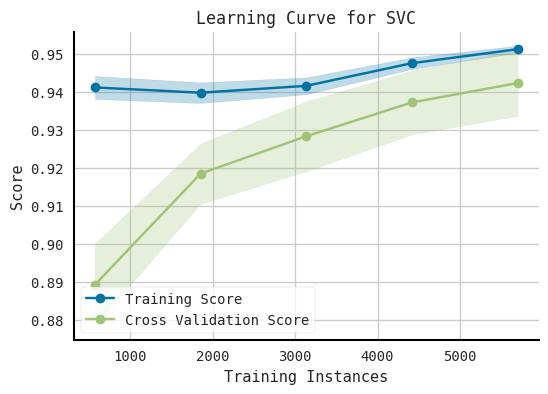

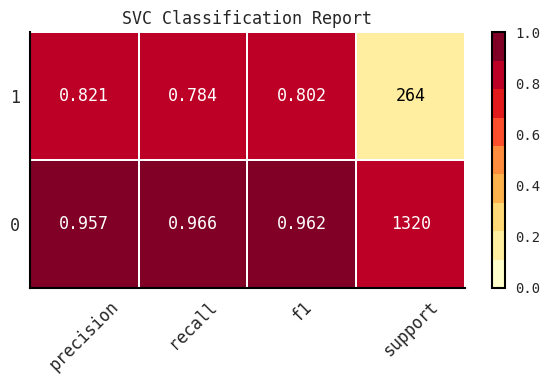

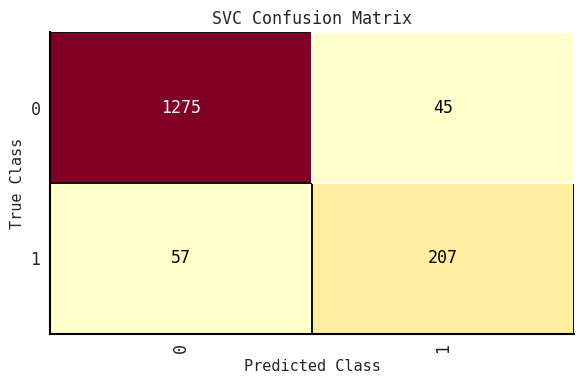

In [77]:

eval_model(estimator=SVC(random_state=42), X=X_bankrupt, y=y_bankrupt,
                       param_1_name='max_iter',param_1_range = [100,300,500,700],
                       param_2_name='kernel',param_2_range = ['sigmoid','poly','rbf'],
                       n_splits=10,labels=['0','1'],test_size=0.2)

k-Nearest Neighbors. You should "implement" (the quotes mean I don't mean it: steal the code) kNN. Use different values of k.


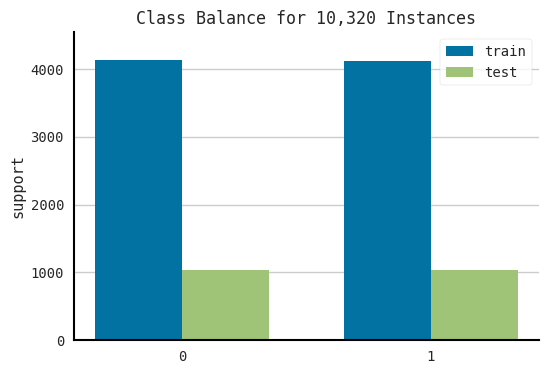

Grid Search best params:  {'leaf_size': 20, 'n_neighbors': 6}
mean_fit_score_time by paramm:                                                0
{'leaf_size': 20, 'n_neighbors': 2}    0.425749
{'leaf_size': 20, 'n_neighbors': 4}    0.242725
{'leaf_size': 20, 'n_neighbors': 6}    0.246815
{'leaf_size': 20, 'n_neighbors': 8}    0.242874
{'leaf_size': 20, 'n_neighbors': 10}   0.249182
{'leaf_size': 50, 'n_neighbors': 2}    0.408954
{'leaf_size': 50, 'n_neighbors': 4}    0.246890
{'leaf_size': 50, 'n_neighbors': 6}    0.245394
{'leaf_size': 50, 'n_neighbors': 8}    0.242857
{'leaf_size': 50, 'n_neighbors': 10}   0.390132
{'leaf_size': 100, 'n_neighbors': 2}   0.271611
{'leaf_size': 100, 'n_neighbors': 4}   0.242796
{'leaf_size': 100, 'n_neighbors': 6}   0.243756
{'leaf_size': 100, 'n_neighbors': 8}   0.250115
{'leaf_size': 100, 'n_neighbors': 10}  0.415548
Grid search time:  43.653990507125854


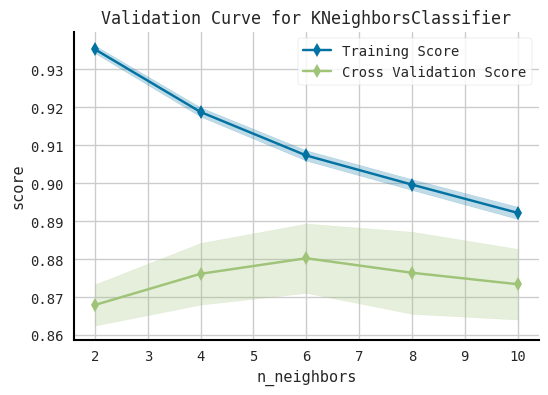

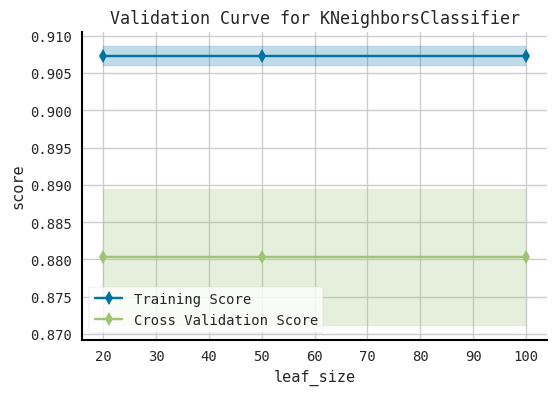

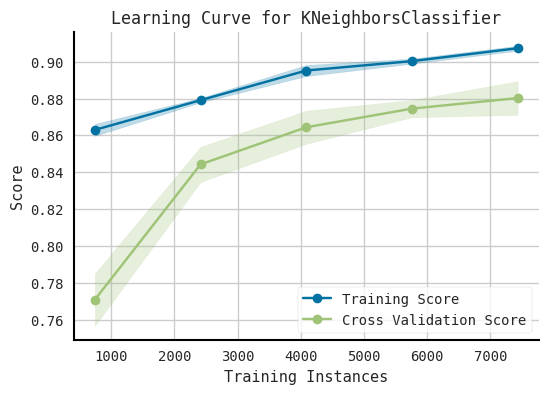

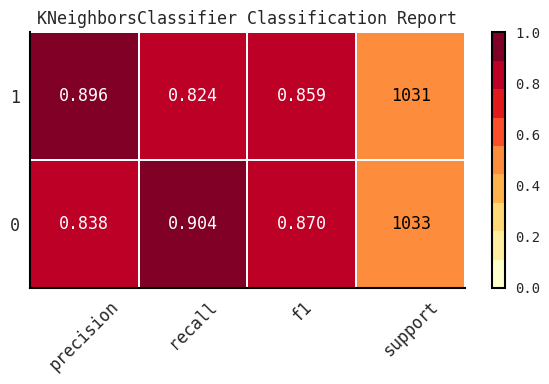

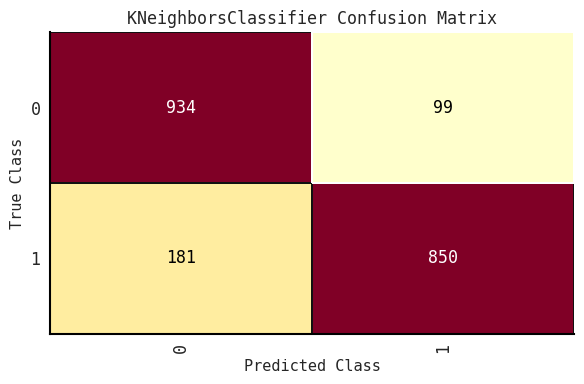

In [78]:
# KNN: K
# https://www.datacamp.com/tutorial/k-nearest-neighbor-classification-scikit-learn
from sklearn.neighbors import KNeighborsClassifier

eval_model(estimator=KNeighborsClassifier(), X=X_housing, y=y_housing,
                       param_1_name='n_neighbors',param_1_range = [2,4,6,8,10],
                       param_2_name='leaf_size',param_2_range = [20,50,100],
                       n_splits=10,labels=['0','1'],test_size=0.2)

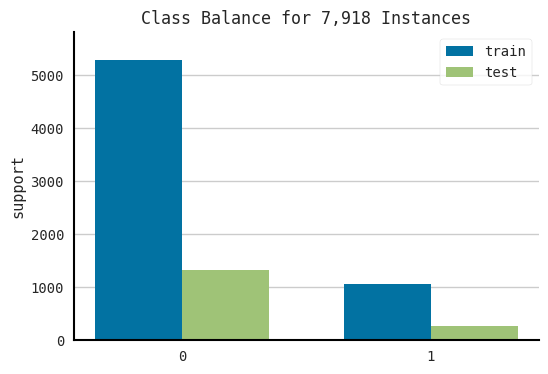

Grid Search best params:  {'leaf_size': 20, 'n_neighbors': 2}
mean_fit_score_time by paramm:                                                0
{'leaf_size': 20, 'n_neighbors': 2}    0.078724
{'leaf_size': 20, 'n_neighbors': 4}    0.099201
{'leaf_size': 20, 'n_neighbors': 6}    0.215694
{'leaf_size': 20, 'n_neighbors': 8}    0.076024
{'leaf_size': 20, 'n_neighbors': 10}   0.073485
{'leaf_size': 50, 'n_neighbors': 2}    0.071154
{'leaf_size': 50, 'n_neighbors': 4}    0.072248
{'leaf_size': 50, 'n_neighbors': 6}    0.074623
{'leaf_size': 50, 'n_neighbors': 8}    0.075148
{'leaf_size': 50, 'n_neighbors': 10}   0.075612
{'leaf_size': 100, 'n_neighbors': 2}   0.076707
{'leaf_size': 100, 'n_neighbors': 4}   0.071082
{'leaf_size': 100, 'n_neighbors': 6}   0.073470
{'leaf_size': 100, 'n_neighbors': 8}   0.071565
{'leaf_size': 100, 'n_neighbors': 10}  0.076814
Grid search time:  12.8155038356781


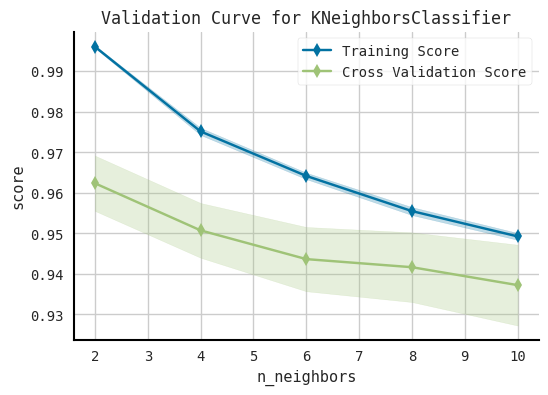

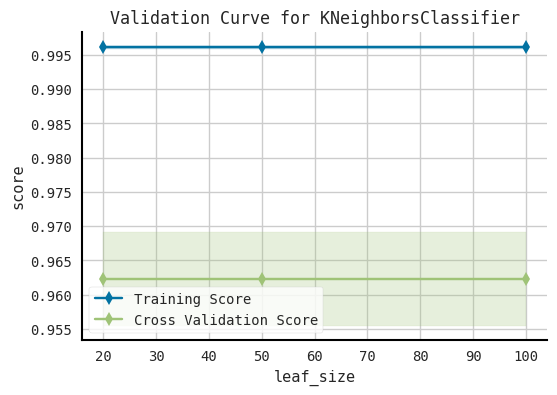

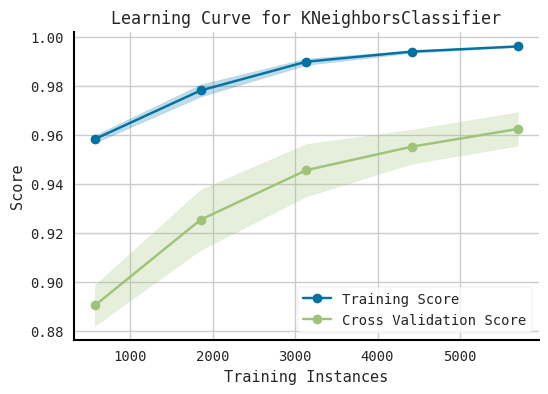

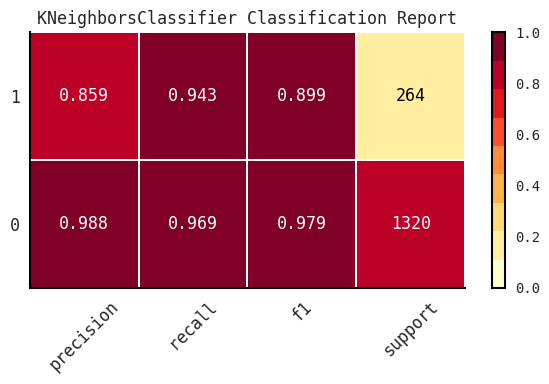

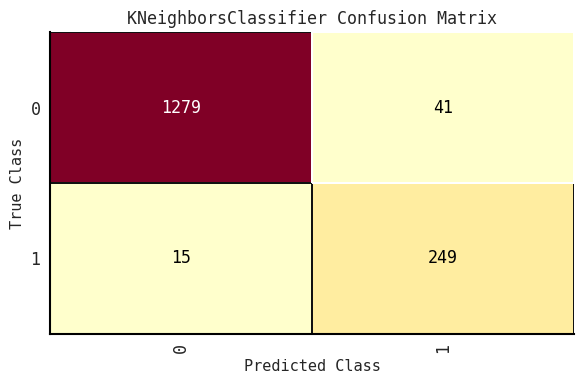

In [79]:
eval_model(estimator=KNeighborsClassifier(), X=X_bankrupt, y=y_bankrupt,
                       param_1_name='n_neighbors',param_1_range = [2,4,6,8,10],
                       param_2_name='leaf_size',param_2_range = [20,50,100],
                       n_splits=10,labels=['0','1'],test_size=0.2)